Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import zipfile
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import random

In [2]:
%matplotlib inline

In [3]:
# Training settings
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(seed)

In [5]:
device = 'cuda'

In [6]:
base_dir = "/home/msalvaris/data/dogs-vs-cats-redux-kernels-edition"

# with zipfile.ZipFile(os.path.join(base_dir,'train.zip')) as train_zip:
#     train_zip.extractall(base_dir)
    
# with zipfile.ZipFile(os.path.join(base_dir,'test.zip')) as test_zip:
#     test_zip.extractall(base_dir)


In [7]:
train_list = glob.glob(os.path.join(base_dir,"train",'*.jpg'))
test_list = glob.glob(os.path.join(base_dir, "test", '*.jpg'))

In [8]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [9]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

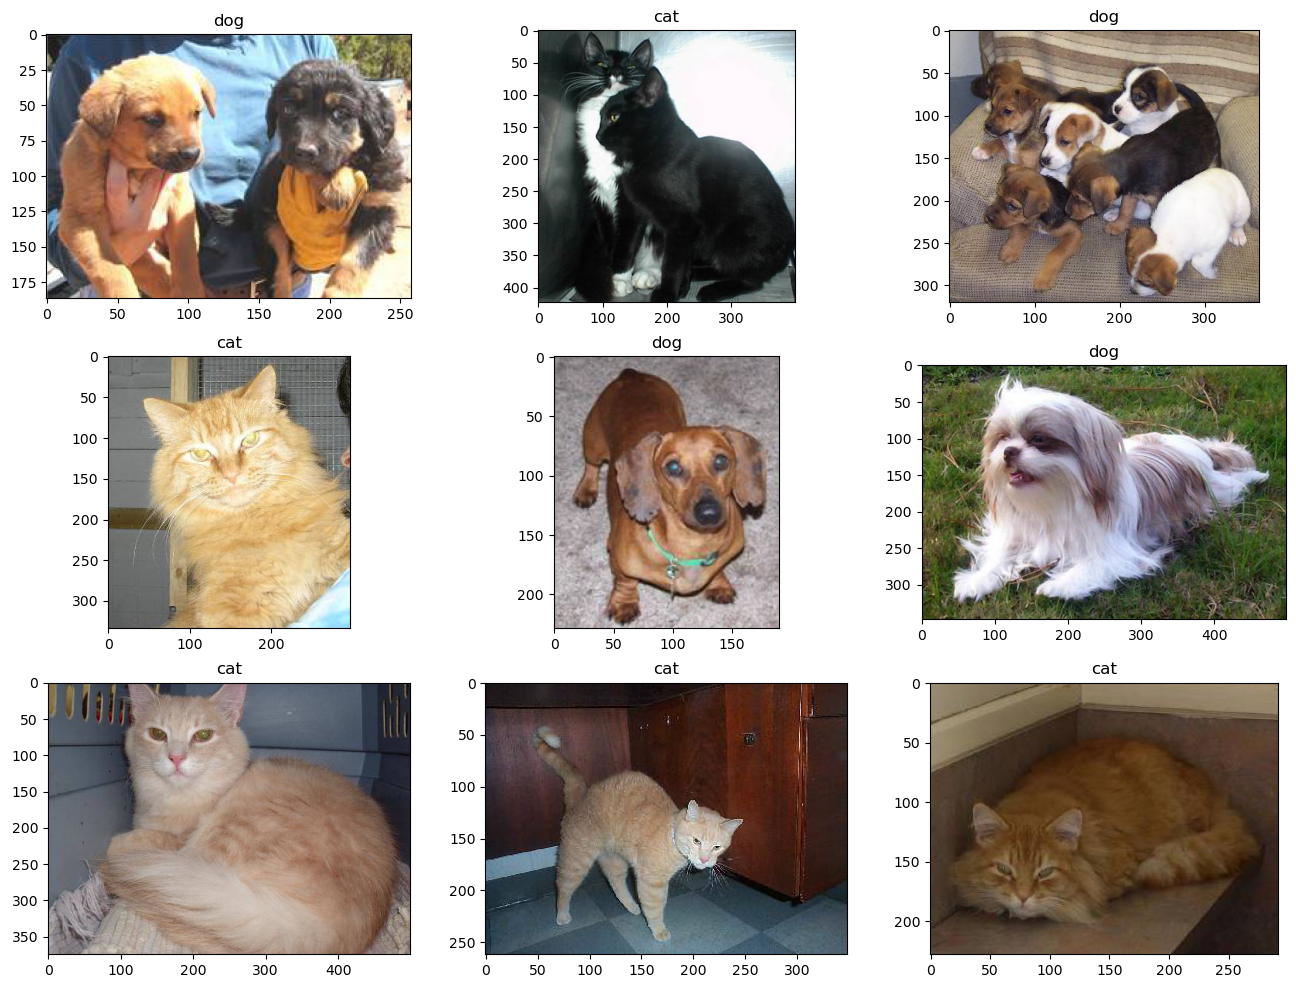

In [10]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [11]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

In [12]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0

        return img_transformed, label

In [13]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(test_list, transform=test_transforms)

In [14]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True, num_workers=8)
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=False, num_workers=8)

In [15]:

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)
        print(f"image_height image_width {image_height}")
        print(f"patch_height patch_width {patch_height}")

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        print(f"patch_dim {patch_dim}")
        print(f"num_patches {num_patches}")
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [16]:


class MAE(nn.Module):
    def __init__(
        self,
        *,
        encoder,
        decoder_dim,
        masking_ratio = 0.75,
        decoder_depth = 1,
        decoder_heads = 8,
        decoder_dim_head = 64
    ):
        super().__init__()
        assert masking_ratio > 0 and masking_ratio < 1, 'masking ratio must be kept between 0 and 1'
        self.masking_ratio = masking_ratio

        # extract some hyperparameters and functions from encoder (vision transformer to be trained)

        self.encoder = encoder
        num_patches, encoder_dim = encoder.pos_embedding.shape[-2:]

        self.to_patch = encoder.to_patch_embedding[0]
        self.patch_to_emb = nn.Sequential(*encoder.to_patch_embedding[1:])

        pixel_values_per_patch = encoder.to_patch_embedding[2].weight.shape[-1]

        # decoder parameters
        self.decoder_dim = decoder_dim
        self.enc_to_dec = nn.Linear(encoder_dim, decoder_dim) if encoder_dim != decoder_dim else nn.Identity()
        self.mask_token = nn.Parameter(torch.randn(decoder_dim))
        self.decoder = Transformer(dim = decoder_dim, depth = decoder_depth, heads = decoder_heads, dim_head = decoder_dim_head, mlp_dim = decoder_dim * 4)
        self.decoder_pos_emb = nn.Embedding(num_patches, decoder_dim)
        self.to_pixels = nn.Linear(decoder_dim, pixel_values_per_patch)

    def forward(self, img):
        device = img.device

        # get patches

        patches = self.to_patch(img)
        batch, num_patches, *_ = patches.shape

        # patch to encoder tokens and add positions

        tokens = self.patch_to_emb(patches)
        if self.encoder.pool == "cls":
            tokens += self.encoder.pos_embedding[:, 1:(num_patches + 1)]
        elif self.encoder.pool == "mean":
            tokens += self.encoder.pos_embedding.to(device, dtype=tokens.dtype) 

        # calculate of patches needed to be masked, and get random indices, dividing it up for mask vs unmasked

        num_masked = int(self.masking_ratio * num_patches)
        rand_indices = torch.rand(batch, num_patches, device = device).argsort(dim = -1)
        masked_indices, unmasked_indices = rand_indices[:, :num_masked], rand_indices[:, num_masked:]

        # get the unmasked tokens to be encoded

        batch_range = torch.arange(batch, device = device)[:, None]
        tokens = tokens[batch_range, unmasked_indices]

        # get the patches to be masked for the final reconstruction loss

        masked_patches = patches[batch_range, masked_indices]

        # attend with vision transformer

        encoded_tokens = self.encoder.transformer(tokens)

        # project encoder to decoder dimensions, if they are not equal - the paper says you can get away with a smaller dimension for decoder

        decoder_tokens = self.enc_to_dec(encoded_tokens)

        # reapply decoder position embedding to unmasked tokens

        unmasked_decoder_tokens = decoder_tokens + self.decoder_pos_emb(unmasked_indices)

        # repeat mask tokens for number of masked, and add the positions using the masked indices derived above

        mask_tokens = repeat(self.mask_token, 'd -> b n d', b = batch, n = num_masked)
        mask_tokens = mask_tokens + self.decoder_pos_emb(masked_indices)

        # concat the masked tokens to the decoder tokens and attend with decoder
        
        decoder_tokens = torch.zeros(batch, num_patches, self.decoder_dim, device=device)
        decoder_tokens[batch_range, unmasked_indices] = unmasked_decoder_tokens
        decoder_tokens[batch_range, masked_indices] = mask_tokens
        decoded_tokens = self.decoder(decoder_tokens)

        # splice out the mask tokens and project to pixel values

        mask_tokens = decoded_tokens[batch_range, masked_indices]
        pred_pixel_values = self.to_pixels(mask_tokens)

        # calculate reconstruction loss

        recon_loss = F.mse_loss(pred_pixel_values, masked_patches)
        return recon_loss


In [17]:
model = ViT(
    image_size=224,
    patch_size=32,
    num_classes=2,
    dim=1024,
    channels=3,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

image_height image_width 224
patch_height patch_width 32
patch_dim 3072
num_patches 49


In [18]:
mae = MAE(
    encoder = model,
    masking_ratio = 0.75,   # the paper recommended 75% masked patches
    decoder_dim = 512,      # paper showed good results with just 512
    decoder_depth = 6       # anywhere from 1 to 8
).to(device)

In [19]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [21]:
optim.AdamW??

In [20]:
for epoch in range(epochs):
    epoch_loss = 0

    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        
        loss = mae(data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss / len(train_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f}\n"
    )


Epoch : 1 - loss : 0.5701

Epoch : 2 - loss : 0.5514

Epoch : 3 - loss : 0.5484

Epoch : 4 - loss : 0.5466

Epoch : 5 - loss : 0.5447

Epoch : 6 - loss : 0.5434

Epoch : 7 - loss : 0.5419

Epoch : 8 - loss : 0.5395

Epoch : 9 - loss : 0.5391

Epoch : 10 - loss : 0.5379



KeyboardInterrupt: 

In [17]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [18]:
@torch.no_grad()
def evaluate():
    model.eval()
    epoch_val_accuracy = 0
    epoch_val_loss = 0
    for data, label in valid_loader:
        data = data.to(device)
        label = label.to(device)

        val_output = model(data)
        val_loss = criterion(val_output, label)

        acc = (val_output.argmax(dim=1) == label).float().mean()
        epoch_val_accuracy += acc / len(valid_loader)
        epoch_val_loss += val_loss / len(valid_loader)
            
    out = {
        "accuracy":epoch_val_accuracy,
        "loss": epoch_val_loss
    }
   
    model.train()
    return out

In [19]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    val_results = evaluate()
    epoch_val_loss = val_results["loss"]
    epoch_val_accuracy = val_results["accuracy"]
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )



Epoch : 1 - loss : 0.6760 - acc: 0.5834 - val_loss : 1.0778 - val_acc: 0.2681

Epoch : 2 - loss : 0.6219 - acc: 0.6462 - val_loss : 0.8776 - val_acc: 0.4556

Epoch : 3 - loss : 0.6042 - acc: 0.6662 - val_loss : 0.8432 - val_acc: 0.5341

Epoch : 4 - loss : 0.5856 - acc: 0.6850 - val_loss : 0.9740 - val_acc: 0.5004

Epoch : 5 - loss : 0.5785 - acc: 0.6927 - val_loss : 0.8339 - val_acc: 0.5760

Epoch : 6 - loss : 0.5701 - acc: 0.6984 - val_loss : 0.8448 - val_acc: 0.5466

Epoch : 7 - loss : 0.5620 - acc: 0.7060 - val_loss : 1.0252 - val_acc: 0.4667

Epoch : 8 - loss : 0.5547 - acc: 0.7109 - val_loss : 0.8995 - val_acc: 0.5334

Epoch : 9 - loss : 0.5497 - acc: 0.7182 - val_loss : 1.0148 - val_acc: 0.4878

Epoch : 10 - loss : 0.5459 - acc: 0.7210 - val_loss : 0.9878 - val_acc: 0.5032

Epoch : 11 - loss : 0.5438 - acc: 0.7198 - val_loss : 1.1863 - val_acc: 0.4065

Epoch : 12 - loss : 0.5344 - acc: 0.7295 - val_loss : 1.0334 - val_acc: 0.4907

Epoch : 13 - loss : 0.5367 - acc: 0.7273 - val_lo